In [52]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split, KFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.pipeline import Pipeline
import featuretools as ft
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings("ignore")

In [38]:
df = pd.read_csv('./Data/merged_v2.csv')
df.head()

,longitude,latitude,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
0,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,33.0
1,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,33.0
2,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,33.0
3,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00,33.0,33.0,33.0
4,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04,33.0,33.0,33.0


In [39]:
numerical_features = ['pH', 'Nitrogen', 'Potassium', 'Phosphorus',
       'Sulfur', 'Sand', 'Silt', 'Clay']

In [40]:
X = df[numerical_features]
y = df[['Boron']]
print('shape of feature matrix before transformation:',X.shape)

shape of feature matrix before transformation: (2584, 8)


In [41]:
X['id'] = [i for i in range(X.shape[0])]
y.reset_index(inplace=True,drop=True)



dataframes = {
    "soil_numerical": (X, "id"),
}

trans_primitives = ['divide_by_feature','square_root','divide_numeric','natural_logarithm','multiply_numeric']
feature_matrix,feature_dfs =ft.dfs(dataframes,
                                   target_dataframe_name='soil_numerical', 
                                    trans_primitives=trans_primitives)
print('shape of feature matrix of train with transformations:',feature_matrix.shape)

shape of feature matrix of train with transformations: (2584, 116)


In [42]:
#rows where there are NaNs or Infs present

# for training dataset
indices_to_remove=feature_matrix[feature_matrix.isin([np.nan, np.inf, -np.inf]).any(axis=1)].index
feature_matrix=feature_matrix.drop(axis=1,index=indices_to_remove)
y=y.drop(axis=1,index=indices_to_remove)
#y_train.reset_index(inplace=True,drop=True)
print(feature_matrix.shape,y.shape)

(2583, 116) (2583, 1)


In [43]:
X = feature_matrix.reset_index(drop=True)
y = y.reset_index(drop = True)

In [ ]:
print(X.shape,y.shape)

In [53]:
# nested cross validation - outer loop for finding out the best model 
# and inner loop for finding out the best hyperparameters for each model

# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
models_list = {'xgb':XGBRegressor(),'lasso':Lasso(),'rf':RandomForestRegressor()}
params = {'xgb':{'n_estimators':list(range(5,30,5))},
		  'rf':{'n_estimators':list(range(15,50,5))},
		  'lasso':{'alpha': np.arange(0.00, 0.15, 0.01)}}
for model_name,model in models_list.items():
	print(model_name)
	for i,(train_ix, test_ix) in enumerate(cv_outer.split(X)):
		# split data
		#print(train_ix,test_ix)
		print('Fold :',i)
		X_train, X_test = X.loc[train_ix, :], X.loc[test_ix, :]
		y_train, y_test = y.loc[train_ix], y.loc[test_ix]
		# configure the inner cross-validation procedure
		cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
		search_space = params[model_name]
		# define search
		grid_search = GridSearchCV(model, search_space, scoring='r2', cv=cv_inner, refit=True)
		# execute search
		result = grid_search.fit(X_train, y_train)
		# get the best performing model fit on the whole training set
		best_model = result.best_estimator_
		# evaluate model on the hold out dataset
		y_pred = best_model.predict(X_test)
		# evaluate the model
		r2 = r2_score(y_test, y_pred)
		mae = mean_absolute_error(y_test,y_pred)
		mape = mean_absolute_percentage_error(y_test,y_pred)
		# store the result
		outer_results.append(r2)
		# report progress
		print(f'r2 on test data={r2}, mae on test_data ={mae}, best r2 on cv inner={result.best_score_}, configuration={result.best_params_}')
	print(f'R2 mean:{np.mean(outer_results)}, R2 std:{np.std(outer_results)}')

xgb
Fold : 0
r2 on test data=0.659403383731842, mae on test_data =0.043991178463342995, best r2 on cv inner=0.5890480478604635, configuration={'n_estimators': 10}
Fold : 1
r2 on test data=0.6772900819778442, mae on test_data =0.043283827162653825, best r2 on cv inner=0.5785822073618571, configuration={'n_estimators': 10}
Fold : 2
r2 on test data=0.6366040706634521, mae on test_data =0.04712929454858411, best r2 on cv inner=0.6032796104749044, configuration={'n_estimators': 10}
Fold : 3
r2 on test data=0.5377679467201233, mae on test_data =0.05098685810856163, best r2 on cv inner=0.6086292068163554, configuration={'n_estimators': 10}
Fold : 4
r2 on test data=0.5890771150588989, mae on test_data =0.04920220408504895, best r2 on cv inner=0.6182563702265421, configuration={'n_estimators': 10}
R2 mean:0.6200285196304322, R2 std:0.05065334468325321
lasso
Fold : 0
r2 on test data=0.6740887326366434, mae on test_data =0.04714070640767706, best r2 on cv inner=0.5876409806607846, configuration={

In [54]:
'''
# can also use cross_val_score as below  instead of creating an outer loop separately.

from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
cv_inner = KFold(n_splits=3,shuffle=True)
cv_outer = KFold(n_splits=10,shuffle=True)
search_space = {'n_estimators':[25,30,35,40,45,50,55]}
model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=model,param_grid=search_space,scoring='r2',refit='r2')
grid_search.fit(X,y)
scores = cross_val_score(estimator=grid_search,scoring='r2',cv=cv_outer,X=X,y=y)
print(np.mean(scores),np.std(scores))
'''

"\n# can also use cross_val_score as below  instead of creating an outer loop separately.\n\nfrom sklearn.model_selection import cross_val_score,KFold,GridSearchCV\nfrom sklearn.ensemble import RandomForestRegressor\ncv_inner = KFold(n_splits=3,shuffle=True)\ncv_outer = KFold(n_splits=10,shuffle=True)\nsearch_space = {'n_estimators':[25,30,35,40,45,50,55]}\nmodel = RandomForestRegressor()\ngrid_search = GridSearchCV(estimator=model,param_grid=search_space,scoring='r2',refit='r2')\ngrid_search.fit(X,y)\nscores = cross_val_score(estimator=grid_search,scoring='r2',cv=cv_outer,X=X,y=y)\nprint(np.mean(scores),np.std(scores))\n"

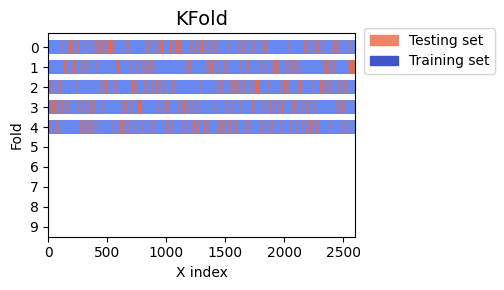

In [55]:
# Visualising kfold split
from matplotlib.patches import Patch

def plot_kfold(cv, X, y, ax, n_splits, xlim_max):
    """
    Plots the indices for a cross-validation object.

    Parameters:
    cv: Cross-validation object
    X: Feature set
    y: Target variable
    ax: Matplotlib axis object
    n_splits: Number of folds in the cross-validation
    xlim_max: Maximum limit for the x-axis
    """
    
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
    
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
        
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)

    # Set y-ticks and labels
    y_ticks = np.arange(n_splits) + 0.5
    ax.set(yticks=y_ticks, yticklabels=range(n_splits),
           xlabel="X index", ylabel="Fold",
           ylim=[n_splits, -0.2], xlim=[0, xlim_max])

    # Set plot title and create legend
    ax.set_title("KFold", fontsize=14)
    legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"),
                      Patch(color=cmap_cv(0.02), label="Training set")]
    ax.legend(handles=legend_patches, loc=(1.03, 0.8))

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))
plot_kfold(cv_outer, X, y, ax, 10,xlim_max=2600)
plt.tight_layout()
fig.subplots_adjust(right=0.6)

### to do
1. read about nested cross validation (https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/)
2. https://machinelearningmastery.com/train-final-machine-learning-model/
3. Include lat long info
4. include feature selection